# Simulated Annealing Approach

This notebook implements a simulated annealing algorithm to optimize tree packing.
The algorithm iteratively perturbs tree positions and orientations, accepting
improvements and occasionally accepting worse solutions to escape local minima.

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys

sys.path.append('.')

In [6]:
import math
import random
from decimal import Decimal, getcontext
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree

from utils.tree import ChristmasTree
from utils.collision import has_collision
from utils.bounding_square import calculate_bounding_square
from utils.place_tree import initialize_greedy
from utils.plot import plot_configuration

getcontext().prec = 25
pd.set_option('display.float_format', '{:.12f}'.format)

In [7]:
def calculate_energy(trees):
    """
    Calculate the energy (objective function) for the current configuration.
    Lower energy is better. In simulated annealing, "energy" is what we minimize.

    Args:
        trees: List of ChristmasTree objects

    Returns:
        Decimal: The bounding square side length (energy to minimize)
    """
    return calculate_bounding_square(trees)

In [8]:
def perturb_translation(trees, tree_idx, max_delta=0.1):
    """
    Create a new configuration by translating a single tree.
    This is one of three "move types" in our simulated annealing.

    Args:
        trees: Current list of ChristmasTree objects
        tree_idx: Index of tree to perturb
        max_delta: Maximum translation distance

    Returns:
        List of ChristmasTree objects (new configuration)
    """
    # Deep copy to avoid modifying original configuration
    new_trees = [deepcopy(t) for t in trees]
    tree = new_trees[tree_idx]

    # Random translation in both x and y directions
    dx = random.uniform(-max_delta, max_delta)
    dy = random.uniform(-max_delta, max_delta)

    # Move the tree using its clean method
    tree.move(dx, dy)

    return new_trees


def perturb_rotation(trees, tree_idx, max_angle=15):
    """
    Create a new configuration by rotating a single tree.
    Rotation can help trees fit together better in tight spaces.

    Args:
        trees: Current list of ChristmasTree objects
        tree_idx: Index of tree to perturb
        max_angle: Maximum rotation angle in degrees

    Returns:
        List of ChristmasTree objects (new configuration)
    """
    new_trees = [deepcopy(t) for t in trees]
    tree = new_trees[tree_idx]

    # Rotate by a random angle (positive or negative)
    delta_angle = random.uniform(-max_angle, max_angle)

    # Rotate the tree using its clean method
    tree.rotate(delta_angle)

    return new_trees


def perturb_swap(trees, idx1, idx2):
    """
    Create a new configuration by swapping positions of two trees.
    This can make larger changes to the configuration than translation/rotation.

    Args:
        trees: Current list of ChristmasTree objects
        idx1: Index of first tree
        idx2: Index of second tree

    Returns:
        List of ChristmasTree objects (new configuration)
    """
    new_trees = [deepcopy(t) for t in trees]

    # Save the positions of both trees
    pos1 = (new_trees[idx1].center_x, new_trees[idx1].center_y)
    pos2 = (new_trees[idx2].center_x, new_trees[idx2].center_y)

    # Swap positions (keeping rotations)
    new_trees[idx1].set_transform(pos2[0], pos2[1], new_trees[idx1].angle)
    new_trees[idx2].set_transform(pos1[0], pos1[1], new_trees[idx2].angle)

    return new_trees

In [9]:
def simulated_annealing(
    initial_trees,
    initial_temp=1.0,
    final_temp=0.01,
    cooling_rate=0.995,
    iterations_per_temp=100,
    verbose=True
):
    """
    Optimize tree configuration using simulated annealing.

    Args:
        initial_trees: Starting configuration
        initial_temp: Starting temperature for annealing
        final_temp: Final temperature (stopping criterion)
        cooling_rate: Rate at which temperature decreases (0 < rate < 1)
        iterations_per_temp: Number of iterations at each temperature
        verbose: Whether to print progress

    Returns:
        tuple: (best_trees, best_energy, history)
    """
    current_trees = [deepcopy(t) for t in initial_trees]
    current_energy = calculate_energy(current_trees)

    best_trees = [deepcopy(t) for t in current_trees]
    best_energy = current_energy

    temperature = initial_temp
    history = []
    total_iterations = 0
    accepted_moves = 0

    n_trees = len(current_trees)

    # Main optimization loop: continue until temperature is very low
    while temperature > final_temp:
        # At each temperature, try many random perturbations
        for _ in range(iterations_per_temp):
            total_iterations += 1

            # Randomly choose a type of perturbation
            move_type = random.choice(['translate', 'rotate', 'swap'])

            # Generate a new candidate configuration
            if move_type == 'translate':
                tree_idx = random.randint(0, n_trees - 1)
                new_trees = perturb_translation(current_trees, tree_idx, max_delta=0.15)
            elif move_type == 'rotate':
                tree_idx = random.randint(0, n_trees - 1)
                new_trees = perturb_rotation(current_trees, tree_idx, max_angle=20)
            else:  # swap
                if n_trees < 2:
                    continue
                idx1, idx2 = random.sample(range(n_trees), 2)
                new_trees = perturb_swap(current_trees, idx1, idx2)

            # Reject configurations with overlapping trees
            if has_collision(new_trees):
                continue

            # Calculate how much worse/better the new configuration is
            new_energy = calculate_energy(new_trees)
            delta_energy = float(new_energy - current_energy)

            # SIMULATED ANNEALING ACCEPTANCE CRITERION:
            # - Always accept improvements (delta_energy < 0)
            # - Sometimes accept worse solutions with probability exp(-delta_energy / temperature)
            #   * High temperature: accept many worse solutions (explore widely)
            #   * Low temperature: rarely accept worse solutions (exploit good regions)
            # This allows escaping local minima!
            if delta_energy < 0 or random.random() < math.exp(-delta_energy / temperature):
                current_trees = new_trees
                current_energy = new_energy
                accepted_moves += 1

                # Track the best solution ever seen
                if current_energy < best_energy:
                    best_trees = [deepcopy(t) for t in current_trees]
                    best_energy = current_energy

        history.append({
            'temperature': temperature,
            'current_energy': float(current_energy),
            'best_energy': float(best_energy),
            'acceptance_rate': accepted_moves / total_iterations
        })

        if verbose and len(history) % 10 == 0:
            print(f"Temp: {temperature:.4f}, Best: {best_energy:.6f}, "
                  f"Current: {current_energy:.6f}, Accept: {accepted_moves}/{total_iterations}")

        # Cool down: temperature *= cooling_rate (e.g., 0.995)
        # This gradually reduces temperature, making the algorithm more greedy over time
        temperature *= cooling_rate

    return best_trees, best_energy, history

In [10]:
def optimize_all_configurations(
    max_trees=200,
    sa_params=None,
    visualize_every=20,
    seed=42
):
    """
    Optimize configurations for all tree counts from 1 to max_trees.

    Args:
        max_trees: Maximum number of trees to optimize
        sa_params: Dictionary of simulated annealing parameters
        visualize_every: Visualize every N configurations
        seed: Random seed for reproducibility

    Returns:
        dict: Mapping from tree count to (trees, side_length)
    """
    if sa_params is None:
        sa_params = {
            'initial_temp': 1.0,
            'final_temp': 0.01,
            'cooling_rate': 0.995,
            'iterations_per_temp': 100
        }

    random.seed(seed)
    configurations = {}

    for n in range(1, max_trees + 1):
        print(f"\n{'='*60}")
        print(f"Optimizing configuration for {n} trees...")
        print(f"{'='*60}")

        # PROGRESSIVE BUILDING STRATEGY:
        # Use the optimized (n-1)-tree configuration and add one more tree
        # This is faster than starting from scratch, but may not find global optimum
        if n == 1:
            initial_trees = initialize_greedy(n, seed=seed)
        else:
            # Start with previous solution + one new tree at origin
            prev_trees = configurations[n-1][0]
            new_tree = ChristmasTree(
                center_x='0',
                center_y='0',
                angle=str(random.uniform(0, 360))
            )
            initial_trees = [deepcopy(t) for t in prev_trees] + [new_tree]

        initial_energy = calculate_energy(initial_trees)
        print(f"Initial energy: {initial_energy:.6f}")

        best_trees, best_energy, history = simulated_annealing(
            initial_trees,
            verbose=(n % 10 == 0),
            **sa_params
        )

        print(f"Final energy: {best_energy:.6f}")
        print(f"Improvement: {float(initial_energy - best_energy):.6f} "
              f"({100 * (1 - float(best_energy/initial_energy)):.2f}%)")

        configurations[n] = (best_trees, best_energy)

        if n % visualize_every == 0 or n <= 5:
            plot_configuration(best_trees, side_length=best_energy,
                             title=f"Optimized Configuration - {n} Trees")

    return configurations

In [11]:
def configurations_to_submission(configurations):
    """
    Convert optimized configurations to Kaggle submission format.

    Args:
        configurations: Dict mapping tree count to (trees, side_length)

    Returns:
        pandas.DataFrame: Submission dataframe
    """
    index = [f'{n:03d}_{t}' for n in range(1, 201) for t in range(n)]
    tree_data = []

    for n in range(1, 201):
        trees, _ = configurations[n]
        for tree in trees:
            tree_data.append([tree.center_x, tree.center_y, tree.angle])

    cols = ['x', 'y', 'deg']
    submission = pd.DataFrame(index=index, columns=cols, data=tree_data).rename_axis('id')

    for col in cols:
        submission[col] = submission[col].astype(float).round(decimals=6)

    for col in submission.columns:
        submission[col] = 's' + submission[col].astype('string')

    return submission

## Run Optimization

This cell runs the full optimization. Adjust parameters as needed.


Optimizing configuration for 1 trees...
Initial energy: 0.838638
Final energy: 0.813178
Improvement: 0.025460 (3.04%)


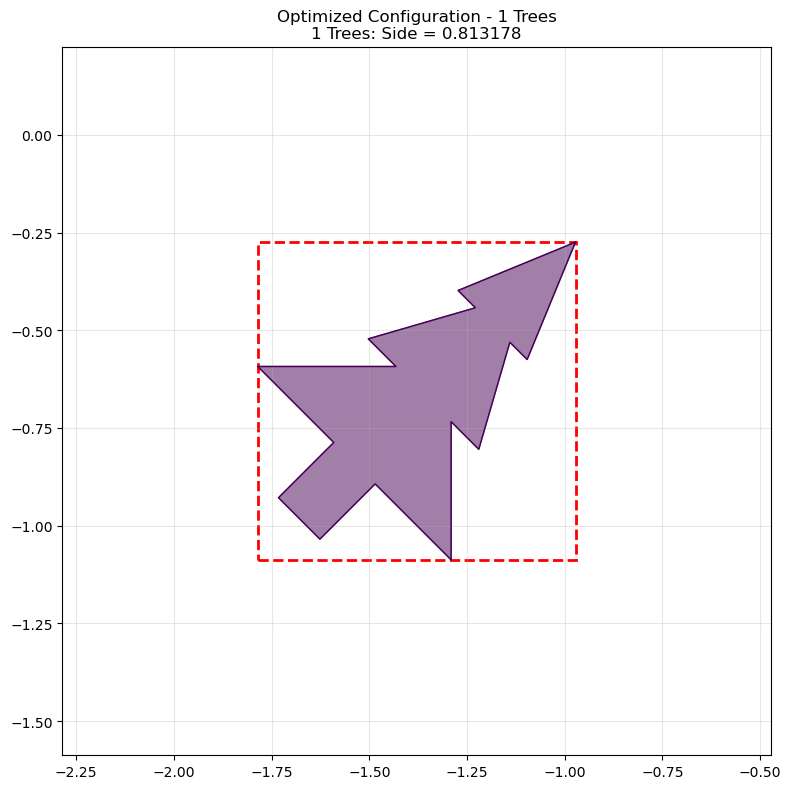


Optimizing configuration for 2 trees...
Initial energy: 1.998696


/Users/sebastiancaicedo/miniconda3/envs/santa-challenge/lib/python3.12/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sebastiancaicedo/miniconda3/envs/santa-challenge/lib/python3.12/site-packages/shapely/predicates.py:980: RuntimeWarning: invalid value encountered in touches
  return lib.touches(a, b, **kwargs)


Final energy: 0.974689
Improvement: 1.024007 (51.23%)


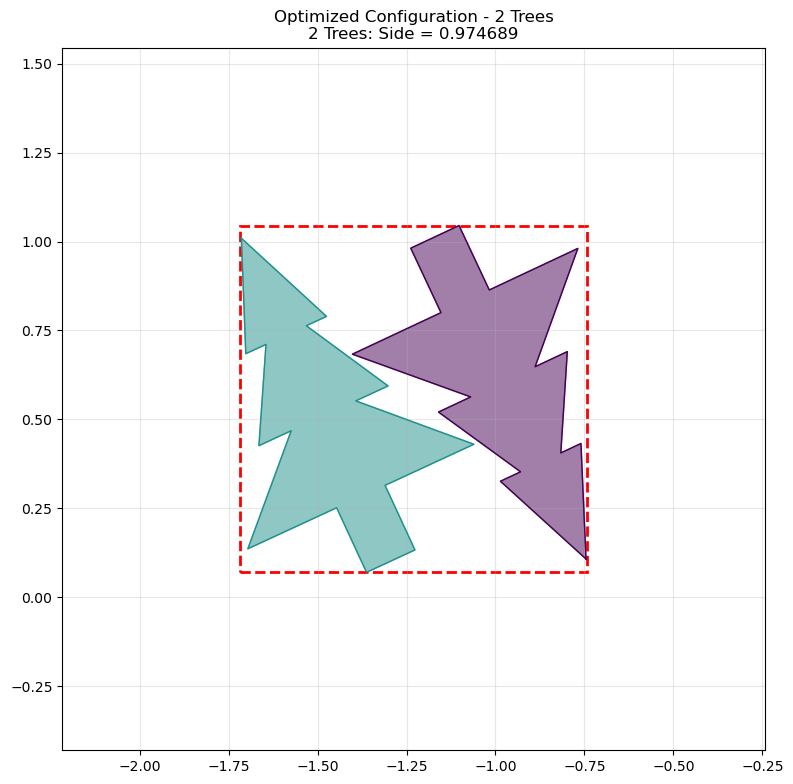

In [12]:
# Example: Optimize a small subset for testing
test_configurations = optimize_all_configurations(
    max_trees=2,
    sa_params={
        'initial_temp': 1.0,
        'final_temp': 0.01,
        'cooling_rate': 0.98,
        'iterations_per_temp': 50
    },
    visualize_every=5,
    seed=42
)

In [13]:
# Calculate total score
total_score = sum(float(side**2) / n for n, (_, side) in test_configurations.items())
print(f"\nTotal score for {len(test_configurations)} configurations: {total_score:.6f}")


Total score for 2 configurations: 1.136269


## Full Run (Uncomment to execute)

This will take a long time to complete. Consider running overnight or
adjusting parameters for faster (but potentially lower quality) results.

In [14]:
# full_configurations = optimize_all_configurations(
#     max_trees=200,
#     sa_params={
#         'initial_temp': 2.0,
#         'final_temp': 0.001,
#         'cooling_rate': 0.997,
#         'iterations_per_temp': 200
#     },
#     visualize_every=20,
#     seed=42
# )
#
# submission = configurations_to_submission(full_configurations)
# submission.to_csv('submission_simulated_annealing.csv')
# print("\nSubmission saved to submission_simulated_annealing.csv")